# Power Outages
This project uses major power outage data in the continental U.S. from January 2000 to July 2016. Here, a major power  outage is defined as a power outage that impacted at least 50,000 customers or caused an unplanned firm load loss of atleast 300MW. Interesting questions to consider include:
- Where and when do major power outages tend to occur?
- What are the characteristics of major power outages with higher severity? Variables to consider include location, time, climate, land-use characteristics, electricity consumption patterns, economic characteristics, etc. What risk factors may an energy company want to look into when predicting the location and severity of its next major power outage?
- What characteristics are associated with each category of cause?
- How have characteristics of major power outages changed over time? Is there a clear trend?

### Getting the Data
The data is downloadable [here](https://engineering.purdue.edu/LASCI/research-data/outages/outagerisks).

A data dictionary is available at this [article](https://www.sciencedirect.com/science/article/pii/S2352340918307182) under *Table 1. Variable descriptions*.

### Cleaning and EDA
- Note that the data is given as an Excel file rather than a CSV. Open the data in Excel or another spreadsheet application and determine which rows and columns of the Excel spreadsheet should be ignored when loading the data in pandas.
- Clean the data.
    - The power outage start date and time is given by `OUTAGE.START.DATE` and `OUTAGE.START.TIME`. It would be preferable if these two columns were combined into one datetime column. Combine `OUTAGE.START.DATE` and `OUTAGE.START.TIME` into a new datetime column called `OUTAGE.START`. Similarly, combine `OUTAGE.RESTORATION.DATE` and `OUTAGE.RESTORATION.TIME` into a new datetime column called `OUTAGE.RESTORATION`.
- Understand the data in ways relevant to your question using univariate and bivariate analysis of the data as well as aggregations.

*Hint 1: pandas can load multiple filetypes: `pd.read_csv`, `pd.read_excel`, `pd.read_html`, `pd.read_json`, etc.*

*Hint 2: `pd.to_datetime` and `pd.to_timedelta` will be useful here.*

*Tip: To visualize geospatial data, consider [Folium](https://python-visualization.github.io/folium/) or another geospatial plotting library.*

### Assessment of Missingness
- Assess the missingness of a column that is not missing by  design.

### Hypothesis Test
Find a hypothesis test to perform. You can use the questions at the top of the notebook for inspiration.

# Summary of Findings

### Introduction
<p>Power outage dataset includes data of power outage information in the continental U.S. from January 2000 to July 2016. A major power outage, for the purpose of this project, is defined as a power outage that impacted at least 50,000 customers or caused an unplanned firm load loss of atleast 300MW.</p>
<p>This data provides valuable information that can be used to conduct future research in various paradigms, such as—state-level power outage risk maps for the continental U.S., predicting demand load loss, analyzing vulnerability of the U.S. states to frequent major power outages, and studying historical trends of major power outages.</p>
<p>Other than basic information of state, climate, time, this dataset also includes electricity consumption patterns, economic characteristics, and land-use characteristics, each with many sub-sections to signify it's characteristics.</p>

#### Main question to concern
- Where and when do major power outages tend to occur?
    - Tested under __Exploratory Data Analysis (EDA)__
    - The question of "where" includes [states, climate region]
    - The question of "when" includes [year, month, time]
- What are the characteristics of major power outages with higher severity? 
    - Missingness of Demand Loss and Customers are assessed under __Assessment of Missingness__
    - Demand Loss and Customers Affected are combined using PCA to create a single measurement for Severity
    - Relationship with Location (TVD), Time (ks), and Climate Category (TVD) tested under __Hypothesis Testing__
    - Relationship with land-use characteristics, electricity consumption patterns, economic characteristics, and Climate anomaly level tested under __Exploratory Data Analysis__
        - Differnt columns within characteristics are combined using PCA to create a single measurement for each characterstic 
- What characteristics are associated with each category of cause?
    - Tested under __Hypothesis Testing__
- How have characteristics of major power outages changed over time? Is there a clear trend?
    - Tested under __Exploratory Data Analysis__

### Cleaning


### Exploratory Data Analysis (EDA)
#### 1) Where does power outage tend to occur?

#### 2) When does power outage tend to occur?

#### 3) Correlation of outage severity vs. characteristics

#### 4) Correlation of cateogry of cause vs. characteristics

#### 5) Characteristics of outage over time

### Assessment of Missingness
TODO

### Hypothesis Test
TODO

# Code

In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import folium
# import json
# import warnings
# warnings.simplefilter(action="ignore", category=RuntimeWarning)
import calendar
from scipy.cluster.vq import whiten
from sklearn.decomposition import PCA
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

import util

## Cleaning

### 1) Load data with useful columns of interest

In [52]:
# Load data
to_drop = ['variables', 'OBS', 'CAUSE.CATEGORY.DETAIL', 'HURRICANE.NAMES']
fp = os.path.join('data', 'outage.xlsx')
df = pd.read_excel(fp, header=0, skiprows=[0, 1, 2, 3, 4, 6]).drop(columns=to_drop) # Load df, skip unuseful rows
df.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01,17:00:00,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
1,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11,18:38:00,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26,20:00:00,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19,04:30:00,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18,02:00:00,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


### 2) Combine START & RESTORATION Date + Time into one column respectively

In [59]:
# Combine date and time into datetime
df['OUTAGE.START'] = (df['OUTAGE.START.DATE'] + 
                      pd.to_timedelta(df['OUTAGE.START.TIME']
                      .astype(str))) # Combine START into date
df['OUTAGE.RESTORATION'] = (df['OUTAGE.RESTORATION.DATE'] +
                            pd.to_timedelta(df['OUTAGE.RESTORATION.TIME']
                            .astype(str))) # Combine RESTORATION into date
outage = df.drop(columns=['OUTAGE.START.DATE', 'OUTAGE.START.TIME',
                          'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME']) # Drop columns
outage.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,OUTAGE.DURATION,...,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
0,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,severe weather,3060.0,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2011-07-01 17:00:00,2011-07-03 20:00:00
1,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,intentional attack,1.0,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2014-05-11 18:38:00,2014-05-11 18:39:00
2,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,severe weather,3000.0,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2010-10-26 20:00:00,2010-10-28 22:00:00
3,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,severe weather,2550.0,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2012-06-19 04:30:00,2012-06-20 23:00:00
4,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,severe weather,1740.0,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2015-07-18 02:00:00,2015-07-19 07:00:00


### 3) Get major power outage (n > 50,000 & MW > 300)

In [60]:
# Maybe need to check the missingness before analysis
major_outage = (outage[(outage['DEMAND.LOSS.MW'] > 300) & # Firm load loss > 300MW
                       (outage['CUSTOMERS.AFFECTED'] > 50000)] # Customers > 50000
                       .reset_index(drop=True)) # Reset index
major_outage.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,OUTAGE.DURATION,...,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
0,2011,4.0,Tennessee,TN,SERC,Central,-0.5,cold,severe weather,5054.0,...,1450.3,1076.2,55.6,7.05,1.72,97.843109,2.156891,2.156891,2011-04-04 11:47:00,2011-04-08 00:01:00
1,2009,6.0,Tennessee,TN,SERC,Central,0.4,normal,severe weather,136.0,...,1450.3,1076.2,55.6,7.05,1.72,97.843109,2.156891,2.156891,2009-06-12 16:37:00,2009-06-12 18:53:00
2,2005,9.0,Wisconsin,WI,RFC,East North Central,0.0,normal,severe weather,4410.0,...,2123.3,1671.5,32.5,3.47,0.90,82.689019,17.312508,3.049041,2005-09-13 18:30:00,2005-09-16 20:00:00
3,2014,6.0,Wisconsin,WI,MRO,East North Central,0.0,normal,severe weather,538.0,...,2123.3,1671.5,32.5,3.47,0.90,82.689019,17.312508,3.049041,2014-06-30 17:55:00,2014-07-01 02:53:00
4,2012,6.0,West Virginia,WV,RFC,Central,-0.1,normal,severe weather,9576.0,...,1409.9,1326.4,40.6,2.66,0.90,99.207594,0.792406,0.792406,2012-06-29 18:24:00,2012-07-06 10:00:00


### 4) PCA for outage severity, and each characteristic

In [64]:
outage.isnull().mean()

YEAR                  0.000000
MONTH                 0.005867
U.S._STATE            0.000000
POSTAL.CODE           0.000000
NERC.REGION           0.000000
CLIMATE.REGION        0.003911
ANOMALY.LEVEL         0.005867
CLIMATE.CATEGORY      0.005867
CAUSE.CATEGORY        0.000000
OUTAGE.DURATION       0.037810
DEMAND.LOSS.MW        0.459583
CUSTOMERS.AFFECTED    0.288787
RES.PRICE             0.014342
COM.PRICE             0.014342
IND.PRICE             0.014342
TOTAL.PRICE           0.014342
RES.SALES             0.014342
COM.SALES             0.014342
IND.SALES             0.014342
TOTAL.SALES           0.014342
RES.PERCEN            0.014342
COM.PERCEN            0.014342
IND.PERCEN            0.014342
RES.CUSTOMERS         0.000000
COM.CUSTOMERS         0.000000
IND.CUSTOMERS         0.000000
TOTAL.CUSTOMERS       0.000000
RES.CUST.PCT          0.000000
COM.CUST.PCT          0.000000
IND.CUST.PCT          0.000000
PC.REALGSP.STATE      0.000000
PC.REALGSP.USA        0.000000
PC.REALG

In [61]:
# Cols of location, time, climate, elect, econ, land characteristics
location = ['U.S._STATE', 'POSTAL.CODE', 'NERC.REGION']
time = ['OUTAGE.DURATION', 'OUTAGE.START', 'OUTAGE.RESTORATION', 'TIME.TILE']
climate = ['CLIMATE.REGION', 'ANOMALY.LEVEL', 'CLIMATE.CATEGORY']
elec_chara = (['RES.PRICE', 'COM.PRICE', 'IND.PRICE', 
               'TOTAL.PRICE', 'RES.SALES', 'COM.SALES',
               'IND.SALES', 'TOTAL.SALES', 'RES.PERCEN', 
               'COM.PERCEN', 'IND.PERCEN', 'RES.CUSTOMERS',
               'COM.CUSTOMERS', 'IND.CUSTOMERS', 'TOTAL.CUSTOMERS',
               'RES.CUST.PCT', 'COM.CUST.PCT', 'IND.CUST.PCT'])
econ_chara = (['PC.REALGSP.STATE', 'PC.REALGSP.USA', 'PC.REALGSP.REL', 
               'PC.REALGSP.CHANGE', 'UTIL.REALGSP', 'TOTAL.REALGSP',
               'UTIL.CONTRI', 'PI.UTIL.OFUSA'])
land_chara = (['POPULATION', 'POPPCT_URBAN', 'POPPCT_UC',
               'POPDEN_URBAN', 'POPDEN_UC', 'POPDEN_RURAL',
               'AREAPCT_URBAN', 'AREAPCT_UC', 'PCT_LAND',
               'PCT_WATER_TOT', 'PCT_WATER_INLAND'])
demand = outage['DEMAND.LOSS.MW']
customer = outage['CUSTOMERS.AFFECTED']
# 'YEAR', 'MONTH', 'CAUSE.CATEGORY', 'DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED'

In [83]:
# Function to compute PCA
def pca_fit(df, names):
    # pull out required data
    dms = []
    for name in names:
        dms.append(df[name])

    # initialize PCA object
    pca = PCA(n_components=1, whiten=True)
    # combine data
    pca_data = np.array(dms).T
    # fit the dimensionality reduction model
    pca_fit = pca.fit_transform(pca_data)
    
    return pca_fit

In [89]:
pca_elec = pca_fit(outage.fillna(0), elec_chara)
pca_econ = pca_fit(outage, econ_chara)
pca_land = pca_fit(outage.fillna(0), land_chara)
outage = (outage.assign(ELEC_CHARA=[elec[0] for elec in pca_elec],
                        ECON_CHARA=[econ[0] for econ in pca_econ],
                        LAND_CHARA=[land[0] for land in pca_land]))
outage

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,OUTAGE.DURATION,...,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION,ELEC_CHARA,ECON_CHARA,LAND_CHARA
0,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,severe weather,3060.0,...,2.14,0.60,91.592666,8.407334,5.478743,2011-07-01 17:00:00,2011-07-03 20:00:00,-0.616168,-0.626816,-0.679064
1,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,intentional attack,1.0,...,2.14,0.60,91.592666,8.407334,5.478743,2014-05-11 18:38:00,2014-05-11 18:39:00,-0.726823,-0.598510,-0.669629
2,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,severe weather,3000.0,...,2.14,0.60,91.592666,8.407334,5.478743,2010-10-26 20:00:00,2010-10-28 22:00:00,-0.736153,-0.636831,-0.682285
3,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,severe weather,2550.0,...,2.14,0.60,91.592666,8.407334,5.478743,2012-06-19 04:30:00,2012-06-20 23:00:00,-0.684369,-0.621319,-0.676266
4,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,severe weather,1740.0,...,2.14,0.60,91.592666,8.407334,5.478743,2015-07-18 02:00:00,2015-07-19 07:00:00,-0.661444,-0.598405,-0.666819
5,2010,11.0,Minnesota,MN,MRO,East North Central,-1.4,cold,severe weather,1860.0,...,2.14,0.60,91.592666,8.407334,5.478743,2010-11-13 15:00:00,2010-11-14 22:00:00,-0.722078,-0.636831,-0.682285
6,2010,7.0,Minnesota,MN,MRO,East North Central,-0.9,cold,severe weather,2970.0,...,2.14,0.60,91.592666,8.407334,5.478743,2010-07-17 20:30:00,2010-07-19 22:00:00,-0.633301,-0.636831,-0.682285
7,2005,6.0,Minnesota,MN,MRO,East North Central,0.2,normal,severe weather,3960.0,...,2.14,0.60,91.592666,8.407334,5.478743,2005-06-08 04:00:00,2005-06-10 22:00:00,-0.705798,-0.635878,-0.698843
8,2015,3.0,Minnesota,MN,MRO,East North Central,0.6,warm,intentional attack,155.0,...,2.14,0.60,91.592666,8.407334,5.478743,2015-03-16 07:31:00,2015-03-16 10:06:00,-0.695372,-0.598405,-0.666819
9,2013,6.0,Minnesota,MN,MRO,East North Central,-0.2,normal,severe weather,3621.0,...,2.14,0.60,91.592666,8.407334,5.478743,2013-06-21 17:39:00,2013-06-24 06:00:00,-0.709349,-0.610304,-0.672796


In [96]:
isnull = outage[land_chara].isnull().any(axis=1)
to_drop = outage[isnull].index

In [104]:
pca_drop_land = pca_fit(outage[land_chara].dropna(), land_chara)
temp = pd.Series([land[0] for land in pca_land]).drop(to_drop)
print(len(pca_drop_land), len(temp))
pd.Series(temp).corr(pd.Series([land[0] for land in pca_drop_land]))

1524 1524


0.9357522155798603

In [82]:
for col in elec_chara:
    print(pd.Series(pca_elec).corr(outage[col].fillna(0)))
# outage['RES.PRICE']
# pca_elec

0.22868860471711175
0.23322828547231086
0.22623778948997836
0.24628555051602843
0.9464301901584209
0.9824017627418942
0.836699876621111
0.9906171218599347
0.10261887563458469
0.24766661216773667
-0.15361532321976223
0.9262162828163106
0.9332313377520184
0.8236922243924969
0.9283981702686231
-0.07478593051807872
0.06123660405733275
0.06629947882456375


## Exploratory Data Analysis
### 1) Where does power outage tend to occur?
- State differences in normal power outage and major power outage

In [6]:
tot = outage['U.S._STATE'].unique()
major = major_outage['U.S._STATE'].unique()
diff = list(set(tot) - set(major))
diff

['Vermont',
 'Wyoming',
 'New Hampshire',
 'Alaska',
 'Montana',
 'Nevada',
 'Mississippi',
 'South Dakota',
 'Missouri',
 'Maine',
 'Delaware',
 'Colorado',
 'North Dakota',
 'Minnesota',
 'Connecticut',
 'Idaho']

- Count number of times normal vs. major power outage occur across STATE

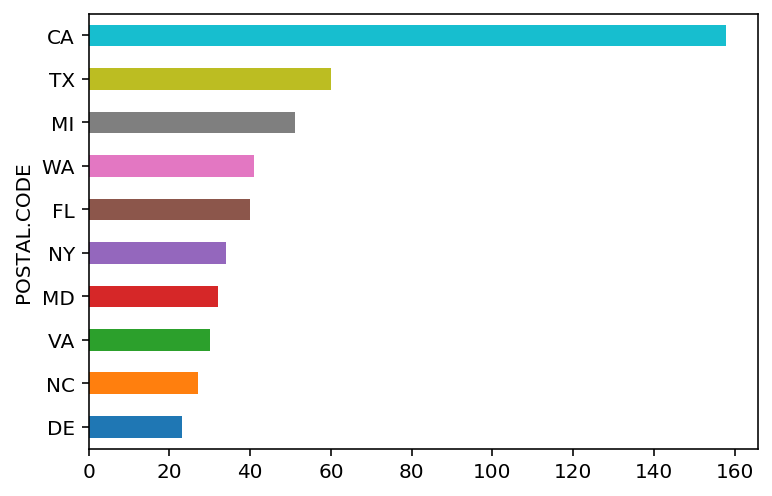

In [7]:
count = outage.groupby('POSTAL.CODE').count()['DEMAND.LOSS.MW']# .sort_values(ascending=False)
count.nlargest(10).sort_values(ascending=True).plot(kind='barh') # Highest 10 demand loss count

In [8]:
util.choropleth(count, 'POSTAL.CODE','DEMAND.LOSS.MW', 'Demand Loss (MW)', 'YlGn')

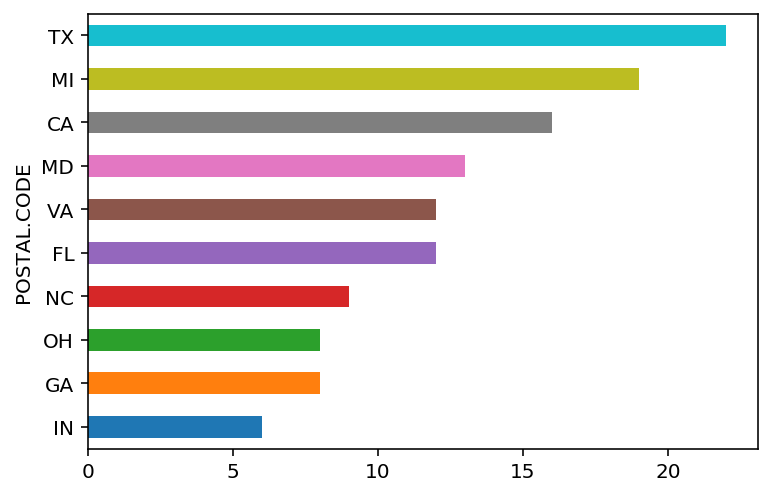

In [9]:
count_m = major_outage.groupby('POSTAL.CODE').count()['DEMAND.LOSS.MW']# .sort_values(ascending=False)
count_m.nlargest(10).sort_values(ascending=True).plot(kind='barh') # Highest 10 demand loss count

In [10]:
util.choropleth(count_m, 'POSTAL.CODE','DEMAND.LOSS.MW', 'Demand Loss (MW)', 'YlGn')

- Average normal vs. major power outage MW across STATE

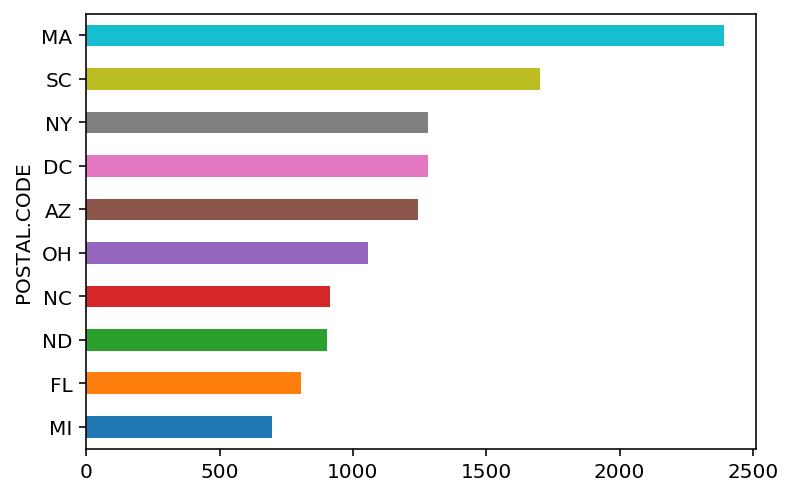

In [11]:
mean_loss = outage.groupby('POSTAL.CODE').mean()['DEMAND.LOSS.MW']# .sort_values(ascending=False)
mean_loss.nlargest(10).sort_values(ascending=True).plot(kind='barh')

In [12]:
util.choropleth(mean_loss, 'POSTAL.CODE','DEMAND.LOSS.MW', 'Demand Loss (MW)', 'YlGn')

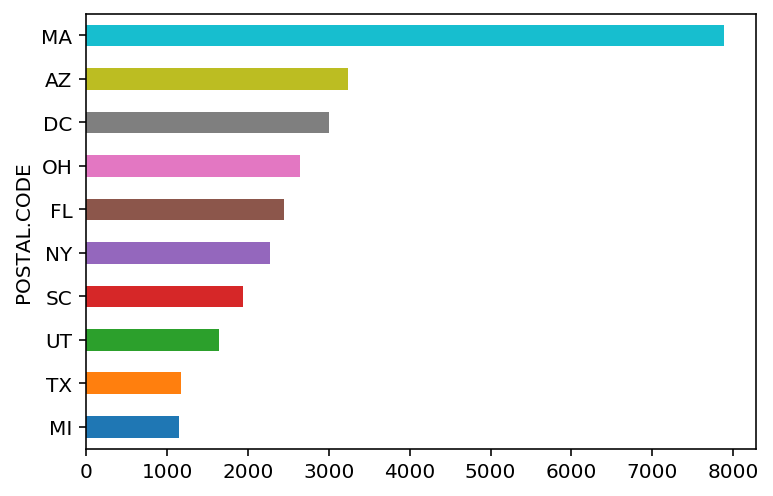

In [13]:
mean_loss_m = major_outage.groupby('POSTAL.CODE').mean()['DEMAND.LOSS.MW']# .sort_values(ascending=False)
mean_loss_m.nlargest(10).sort_values(ascending=True).plot(kind='barh')

In [14]:
util.choropleth(mean_loss_m, 'POSTAL.CODE','DEMAND.LOSS.MW', 'Demand Loss (MW)', 'YlGn') # 

- Count number of times normal vs. major power outage occur across CLIMATE CATEOGRY

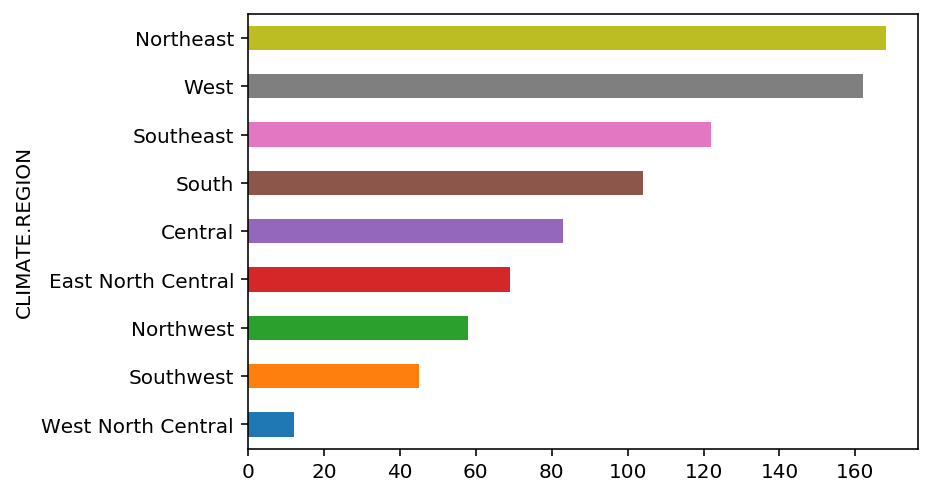

In [45]:
count = outage.groupby('CLIMATE.REGION').count()['DEMAND.LOSS.MW']# .sort_values(ascending=False)
count.nlargest(10).sort_values(ascending=True).plot(kind='barh') # Highest 10 demand loss count

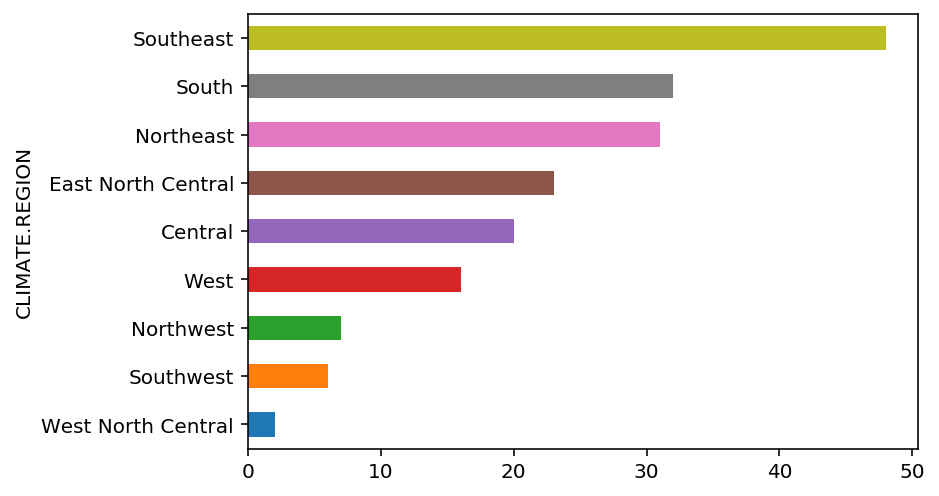

In [46]:
count_m = major_outage.groupby('CLIMATE.').count()['DEMAND.LOSS.MW']# .sort_values(ascending=False)
count_m.nlargest(10).sort_values(ascending=True).plot(kind='barh') # Highest 10 demand loss count

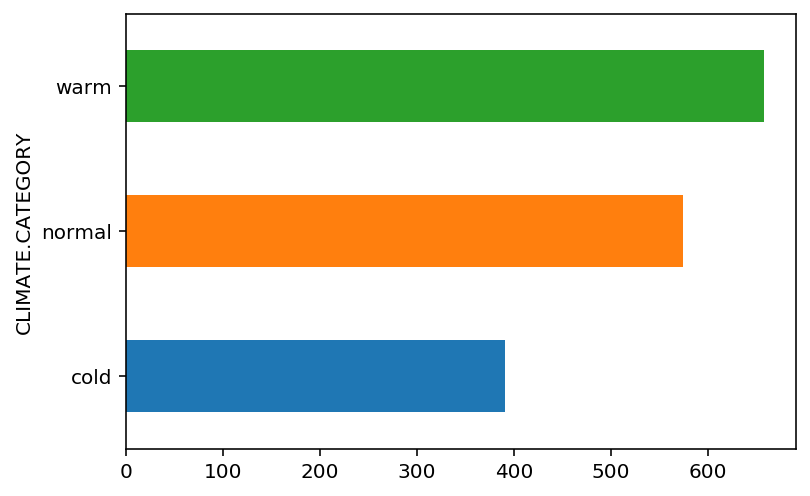

In [17]:
mean_loss = outage.groupby('CLIMATE.CATEGORY').mean()['DEMAND.LOSS.MW']# .sort_values(ascending=False)
mean_loss.nlargest(10).sort_values(ascending=True).plot(kind='barh') # Highest 10 demand loss count

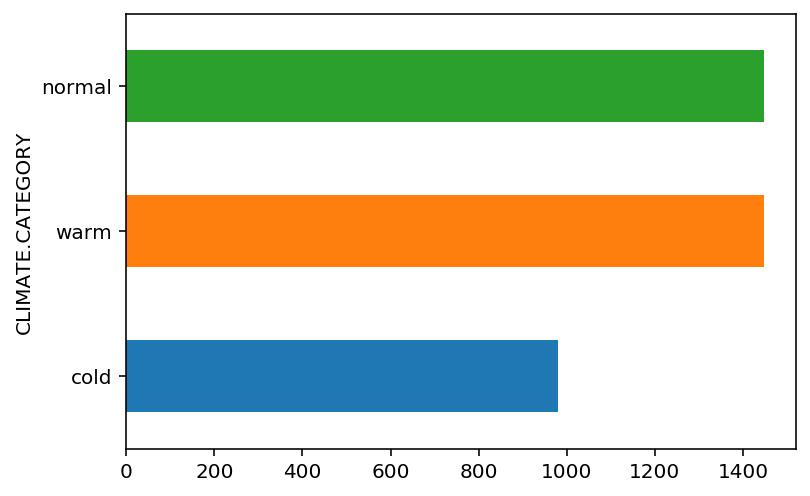

In [18]:
mean_loss_m = major_outage.groupby('CLIMATE.CATEGORY').mean()['DEMAND.LOSS.MW']# .sort_values(ascending=False)
mean_loss_m.nlargest(10).sort_values(ascending=True).plot(kind='barh') # Highest 10 demand loss count

### 2) When does power outage tend to occur?
#### By YEAR
- Count number of times normal vs. major power outage occur across YEAR

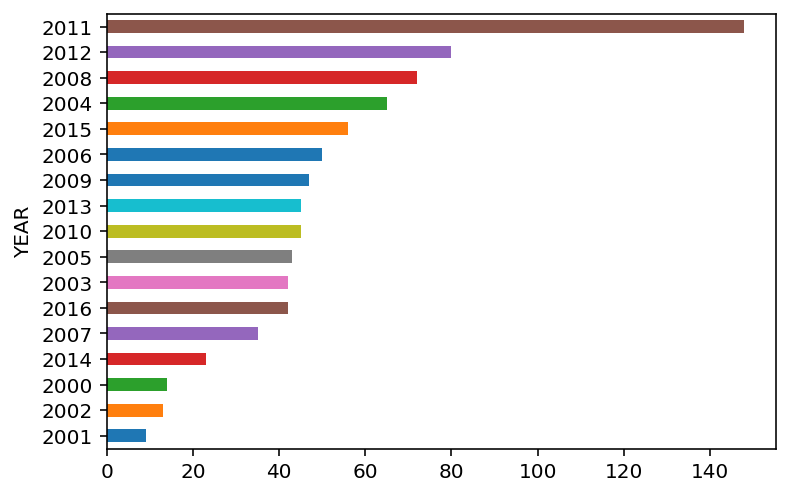

In [19]:
count = outage.groupby('YEAR').count()['DEMAND.LOSS.MW']
count.sort_values(ascending=True).plot(kind='barh')

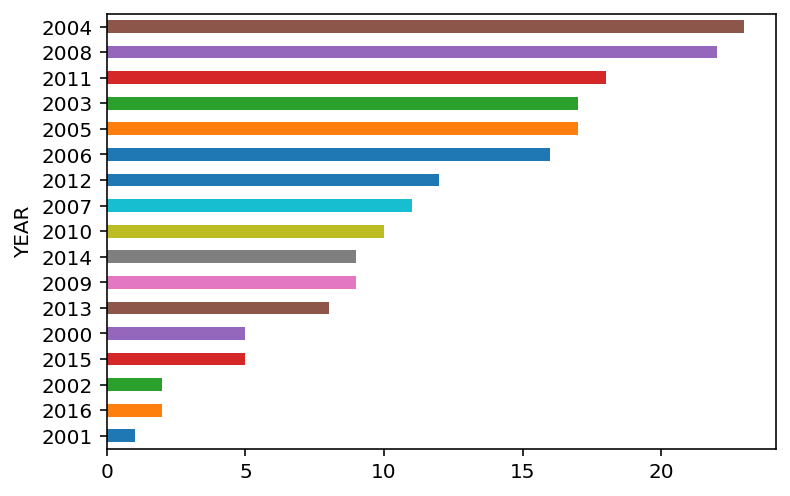

In [20]:
count_m = major_outage.groupby('YEAR').count()['DEMAND.LOSS.MW']
count_m.sort_values(ascending=True).plot(kind='barh')

- Average normal vs. major power outage MW across YEAR

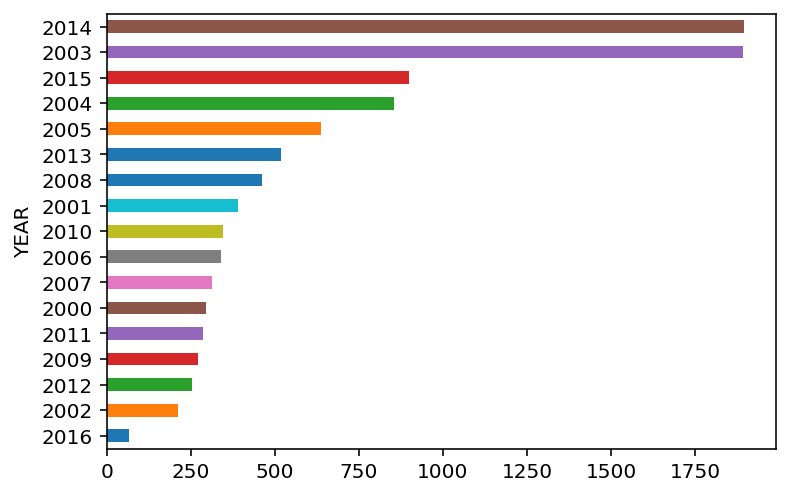

In [21]:
mean_loss = outage.groupby('YEAR').mean()['DEMAND.LOSS.MW']
mean_loss.sort_values(ascending=True).plot(kind='barh')

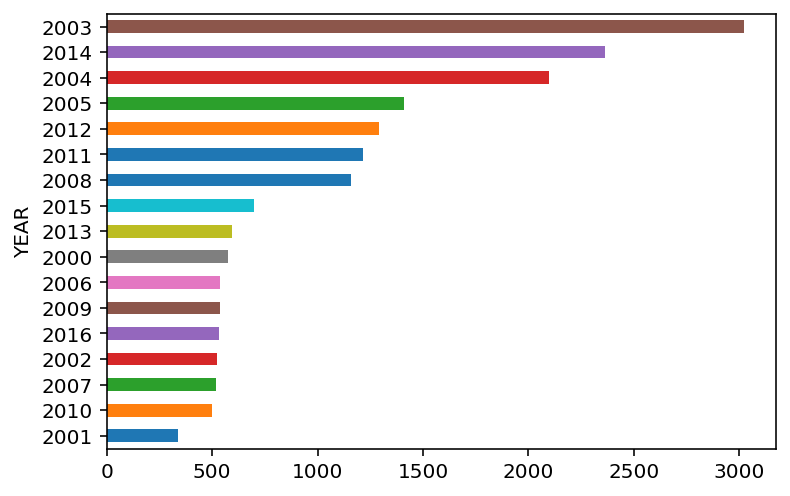

In [22]:
mean_loss_m = major_outage.groupby('YEAR').mean()['DEMAND.LOSS.MW']
mean_loss_m.sort_values(ascending=True).plot(kind='barh')

#### By MONTH
- Count number of times normal vs. major power outage occur across MONTH

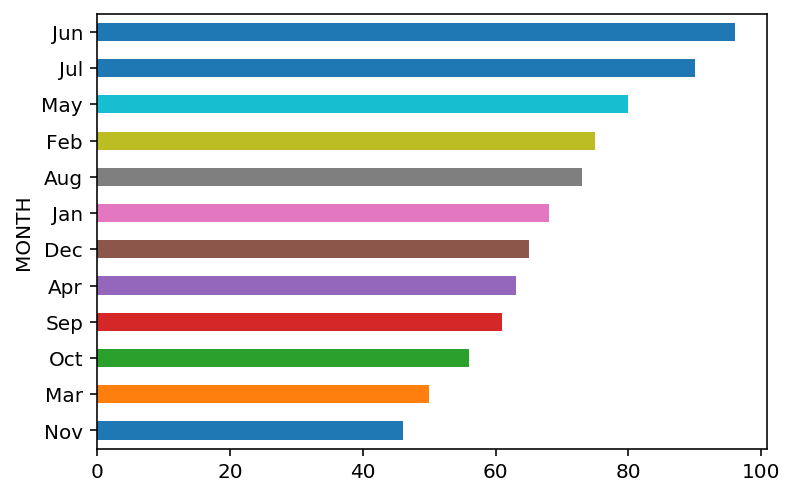

In [23]:
count = outage.groupby('MONTH').count()['DEMAND.LOSS.MW']
count.index = count.index.map(lambda m: calendar.month_abbr[int(m)])
count.sort_values(ascending=True).plot(kind='barh')

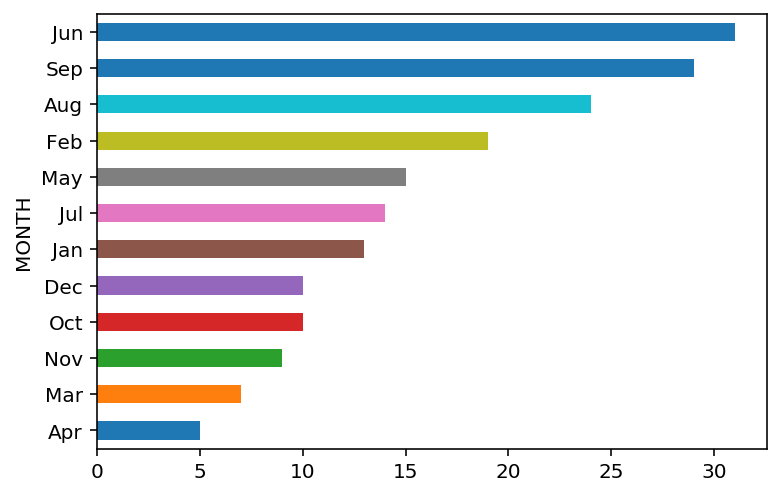

In [24]:
count_m = major_outage.groupby('MONTH').count()['DEMAND.LOSS.MW']
count_m.index = count_m.index.map(lambda m: calendar.month_abbr[int(m)])
count_m.sort_values(ascending=True).plot(kind='barh')

- Average normal vs. major power outage MW across MONTH

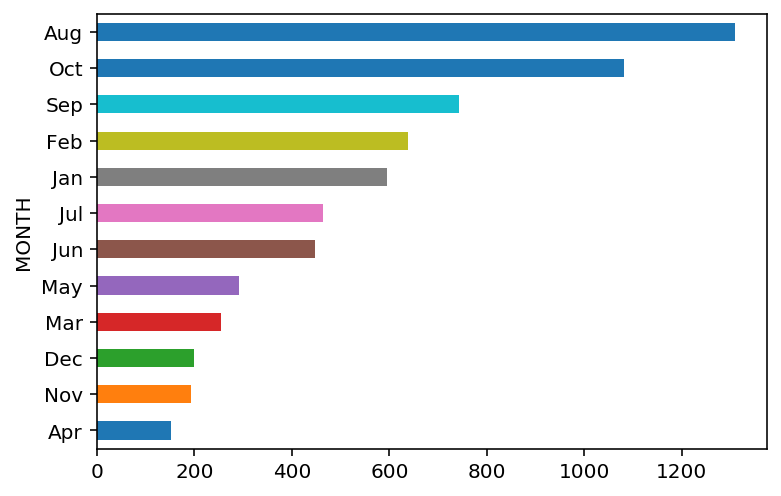

In [25]:
mean_loss = outage.groupby('MONTH').mean()['DEMAND.LOSS.MW']
mean_loss.index = mean_loss.index.map(lambda m: calendar.month_abbr[int(m)])
mean_loss.sort_values(ascending=True).plot(kind='barh')

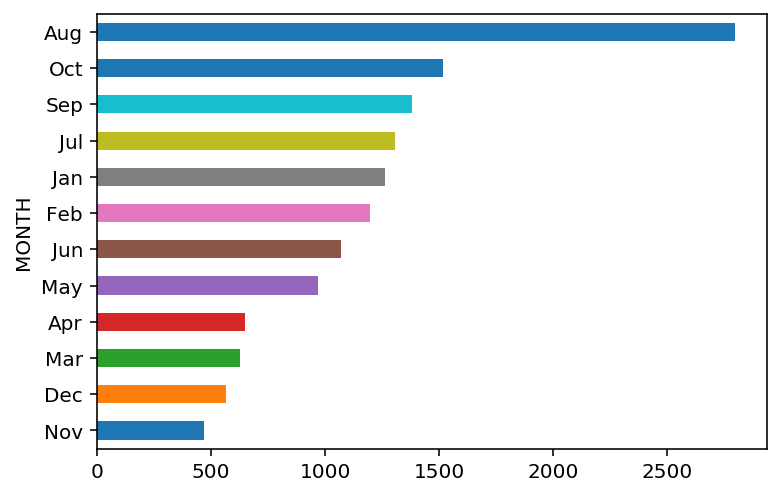

In [26]:
mean_loss_m = major_outage.groupby('MONTH').mean()['DEMAND.LOSS.MW']
mean_loss_m.index = mean_loss_m.index.map(lambda m: calendar.month_abbr[int(m)])
mean_loss_m.sort_values(ascending=True).plot(kind='barh')

#### By TIME
- Count number of times normal vs. major power outage occur across TIME

In [27]:
# maybe useful
# pd.date_range("00:00", "23:59", freq="4H").time.append(pd.date_time()) # Every four hour as a chunk

In [28]:
def get_tile(outage):
    """get the tile of datetime time"""
    qtime_out = outage.copy().set_index('OUTAGE.START') # Deep copy
    tiles = (pd.to_datetime(['00:00:00', '03:59:59', '07:59:59', '11:59:59',
                            '15:59:59', '19:59:59', '23:59:59']).time) # Time intervals
    for i in range(len(tiles) - 1): # Get interval category
        lower, upper = tiles[i], tiles[i+1]
        indices = qtime_out.between_time(lower, upper).index
        for idx in indices:
            qtime_out.loc[idx, 'TIME.TILE'] = str(lower) + ' - ' +str(upper)

    outage['TIME.TILE'] = qtime_out['TIME.TILE'].reset_index(drop=True) # Append col to outage
    return outage

In [29]:
outage, major_outage = get_tile(outage), get_tile(major_outage)

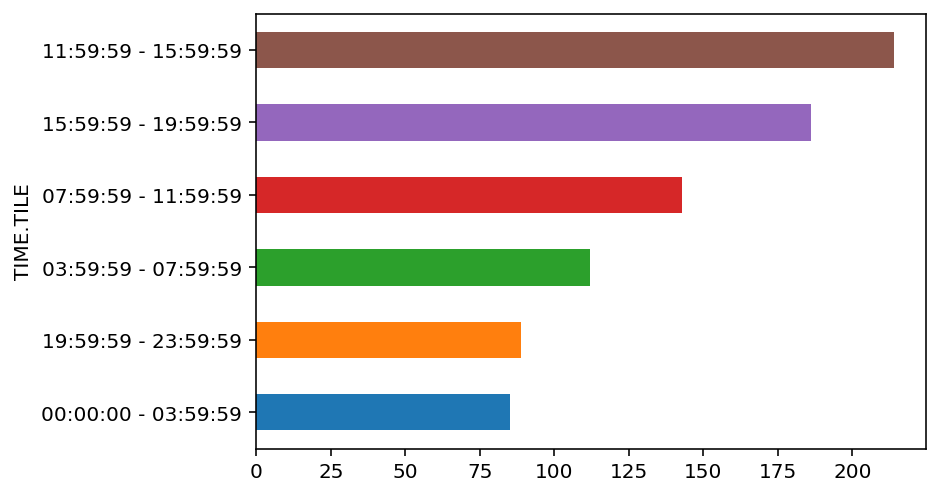

In [30]:
count = outage.groupby('TIME.TILE').count()['DEMAND.LOSS.MW']
count.sort_values(ascending=True).plot(kind='barh')

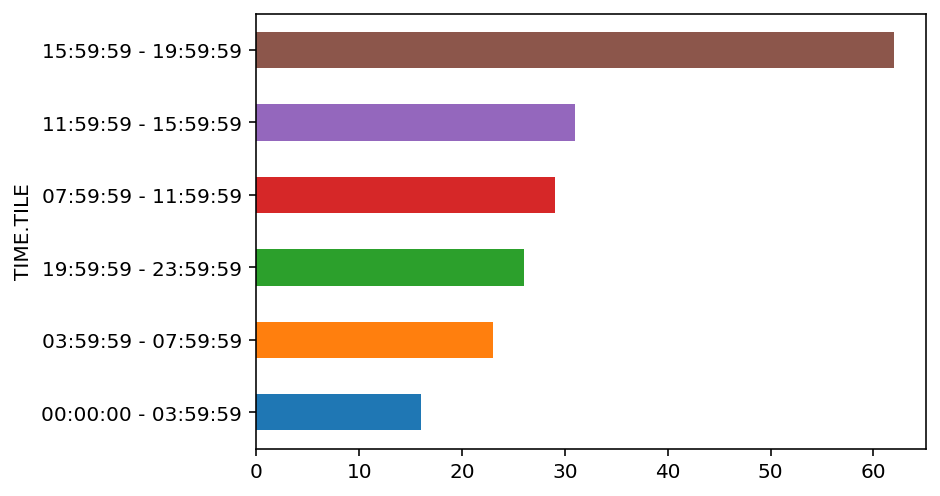

In [31]:
count_m = major_outage.groupby('TIME.TILE').count()['DEMAND.LOSS.MW']
count_m.sort_values(ascending=True).plot(kind='barh')

- Average normal vs. major power outage MW across TIME

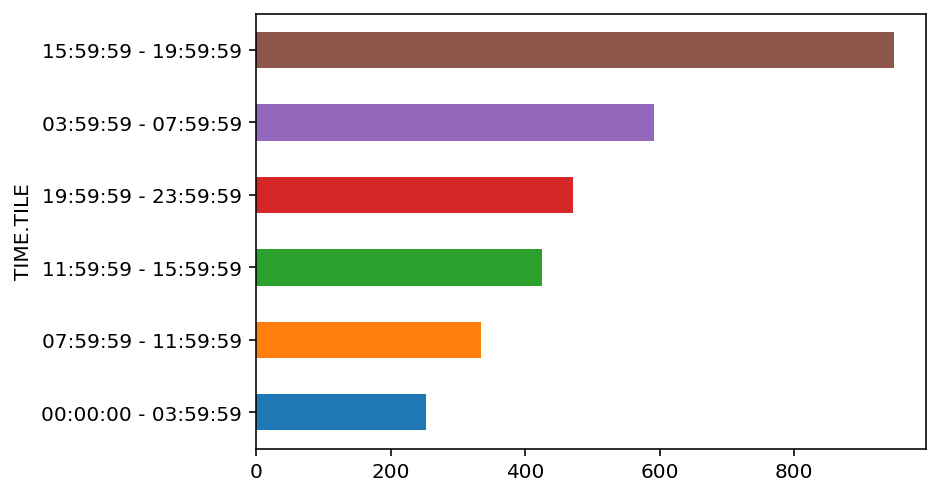

In [32]:
mean_loss = outage.groupby('TIME.TILE').mean()['DEMAND.LOSS.MW']
mean_loss.sort_values(ascending=True).plot(kind='barh')

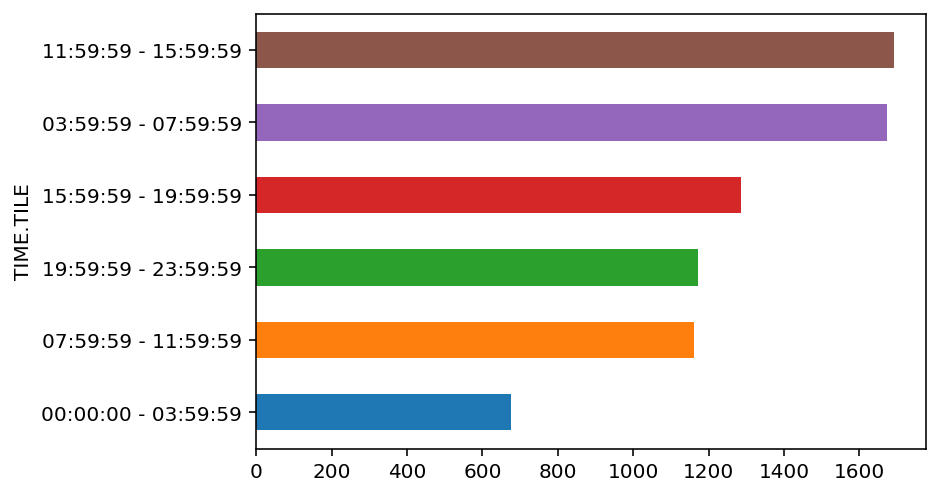

In [33]:
mean_loss_m = major_outage.groupby('TIME.TILE').mean()['DEMAND.LOSS.MW']
mean_loss_m.sort_values(ascending=True).plot(kind='barh')

### 3) Correlation within each category of characteristics

In [48]:
# fig, ax = plt.subplots(figsize=(20,20)) 
# sns.heatmap(outage[elec_chara].corr(), cmap='coolwarm', annot=True, ax=ax)

In [47]:
# fig, ax = plt.subplots(figsize=(10,10)) 
# sns.heatmap(outage[econ_chara].corr(), cmap='coolwarm', annot=True, ax=ax)

In [49]:
# fig, ax = plt.subplots(figsize=(10,10)) 
# sns.heatmap(outage[land_chara].corr(), cmap='coolwarm', annot=True, ax=ax)

In [36]:
# major_outage[time].apply(lambda col: demand.corr(col))

In [37]:
# major_outage[time].apply(lambda col: demand.corr(col))

In [38]:
# major_outage[elec_chara].apply(lambda col: demand.corr(col))

In [39]:
# major_outage[elec_chara].apply(lambda col: customer.corr(col))

In [40]:
# major_outage[econ_chara].apply(lambda col: demand.corr(col))

In [41]:
# major_outage[econ_chara].apply(lambda col: customer.corr(col))

In [42]:
# major_outage[land_chara].apply(lambda col: demand.corr(col))

In [43]:
# major_outage[land_chara].apply(lambda col: customer.corr(col))

In [44]:
# g = sns.relplot(x="total_bill", y="tip",
#                 col="time", hue="day", style="day",
#                 kind="scatter", data=tips)

In [45]:
# sns.heatmap(subjective_corr,
#             vmin=-1,
#             cmap='coolwarm',
#             annot=True,
#             mask = mask);

In [46]:
# outage[].corr()

### 4) Correlation of cateogry of cause vs. characteristics (should do a permutation test)

In [47]:
outage.groupby('CAUSE.CATEGORY').mean().drop(columns=['YEAR', 'MONTH'])
major_outage.groupby('CAUSE.CATEGORY').mean().drop(columns=['YEAR', 'MONTH'])

,ANOMALY.LEVEL,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.PRICE,COM.PRICE,IND.PRICE,TOTAL.PRICE,RES.SALES,COM.SALES,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
CAUSE.CATEGORY,,,,,,,,,,,,,,,,,,,,,
equipment failure,-0.080000,115.800000,1409.600000,361576.800000,10.652000,10.266000,7.612000,9.930000,6.489851e+06,7.290612e+06,...,91.872000,6.484000,3285.120000,1781.400000,19.140000,6.680000,0.738000,93.478905,6.521095,2.573861
severe weather,-0.061935,4562.098039,1173.320513,317222.410256,10.992597,9.414610,6.842597,9.357727,4.824521e+06,4.429260e+06,...,79.039551,9.083333,2325.685256,1439.436129,47.246452,9.485897,1.185833,87.449484,12.550397,3.353408
system operability disruption,-0.369231,860.423077,2133.230769,451207.230769,11.434615,9.890769,7.241154,9.775385,5.770232e+06,6.015600e+06,...,87.089615,7.979615,2808.246154,1619.973077,28.665385,7.728077,0.771154,89.365260,10.634399,2.555823


### 5) Characteristics of major outage over time

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8038b4f0b8>,
      dtype=object)

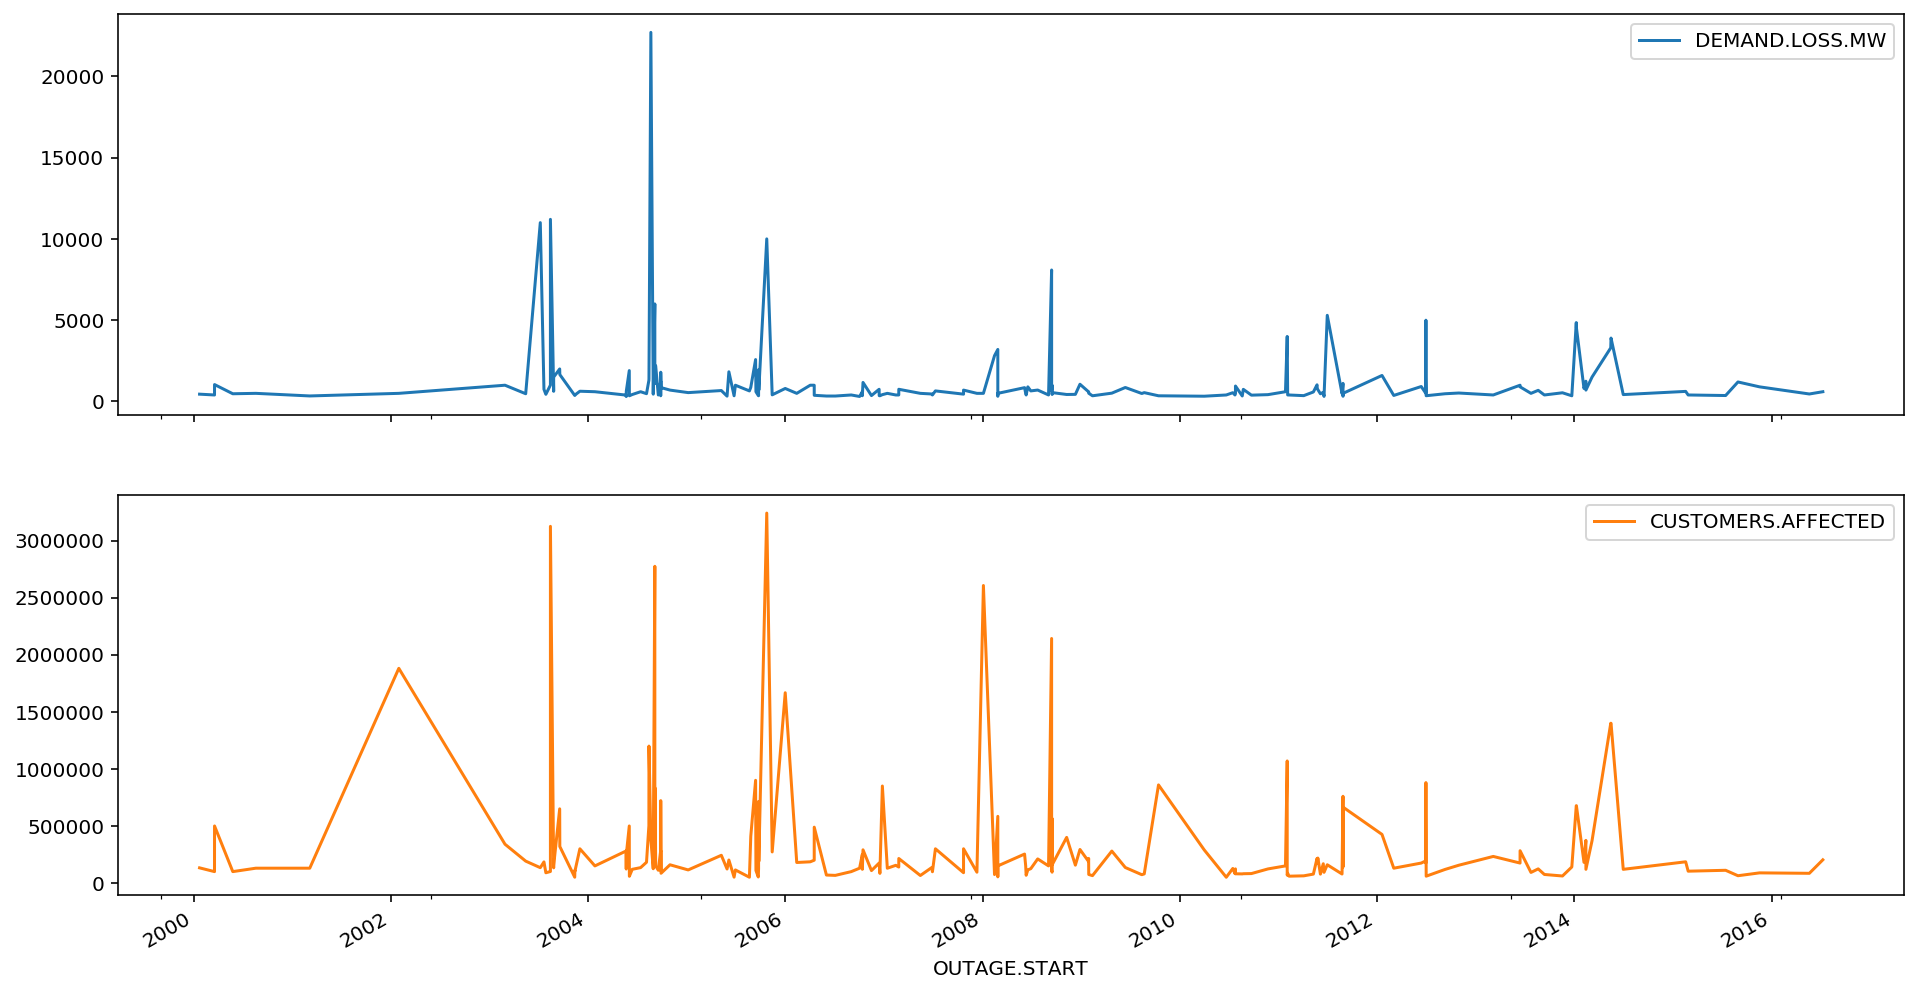

In [62]:
# plot_outage = major_outage.copy().set_index('OUTAGE.START')
# plot_outage.plot(figsize=(16,9))
# plot_outage.plot(subplots=True, figsize=(15,6))
# plot_outage.plot(y=['DEMAND.LOSS.MW', "CUSTOMER.AFFECTED"], figsize=(15,4))
major_outage.plot(subplots=True, x='OUTAGE.START', y=['DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED'], style='-', figsize=(16,9))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f803280d518>,
      dtype=object)

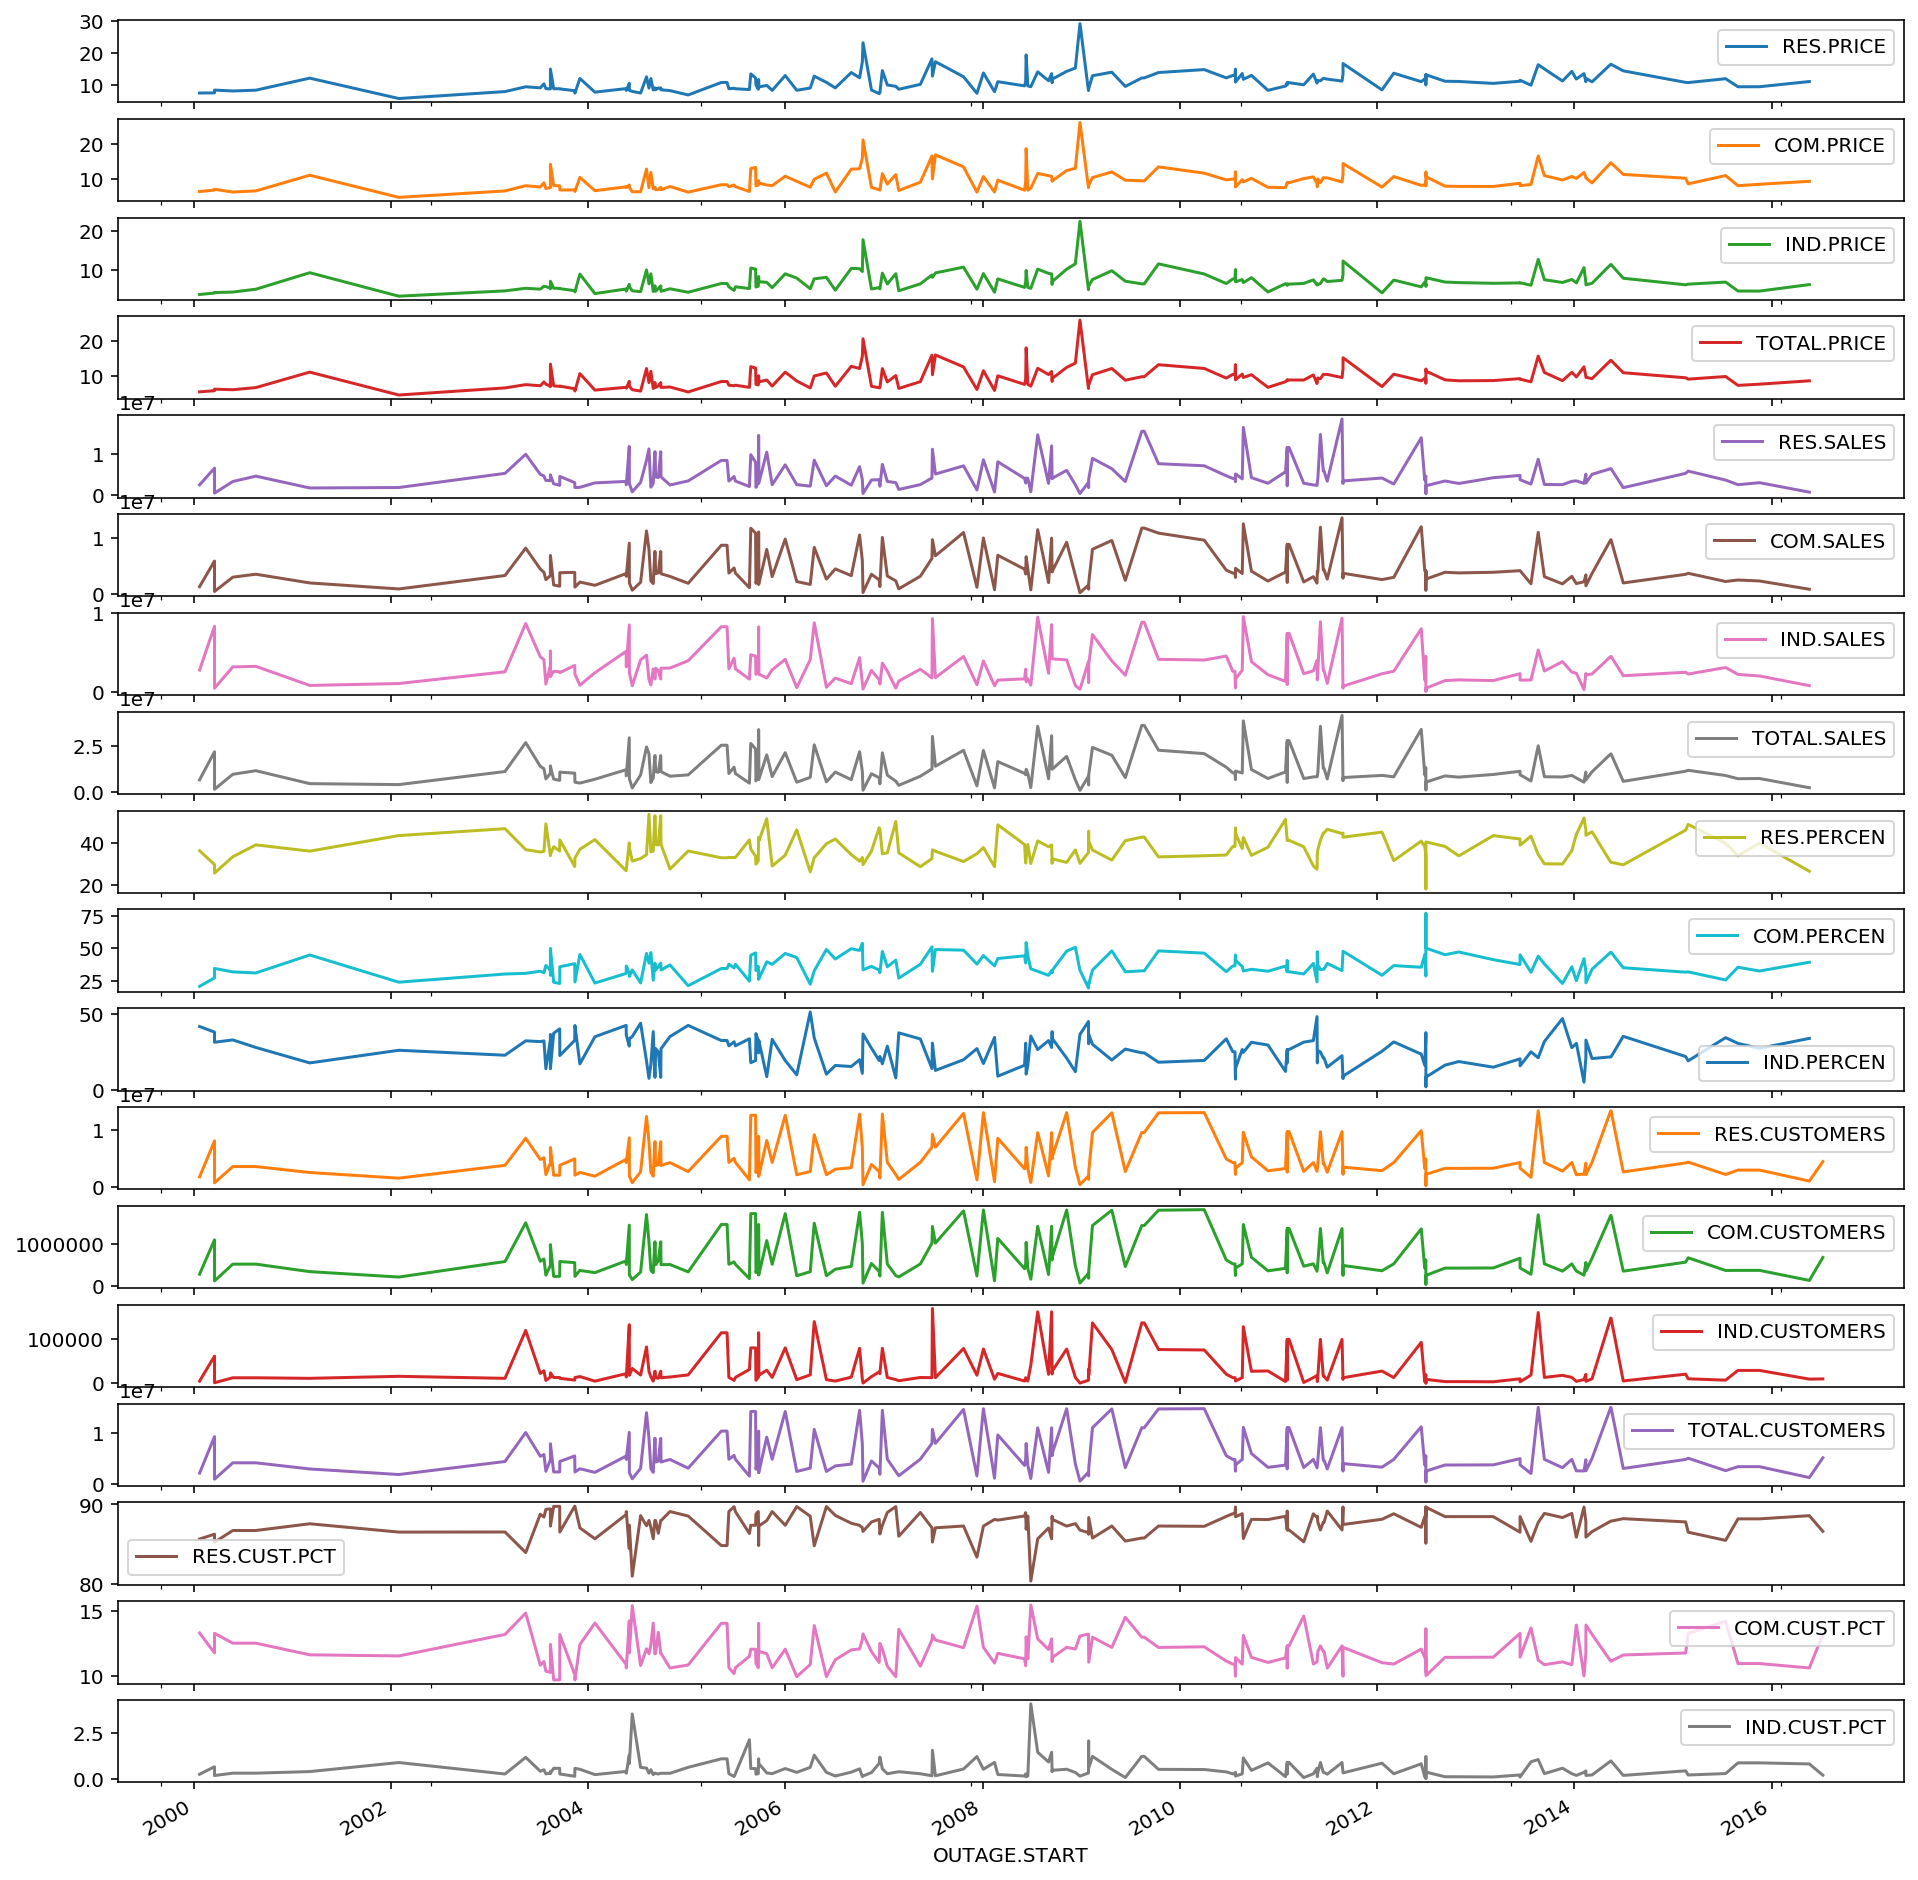

In [67]:
major_outage.plot(subplots=True, x='OUTAGE.START', y=elec_chara, style='-', figsize=(16,18))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8033032ac8>,
      dtype=object)

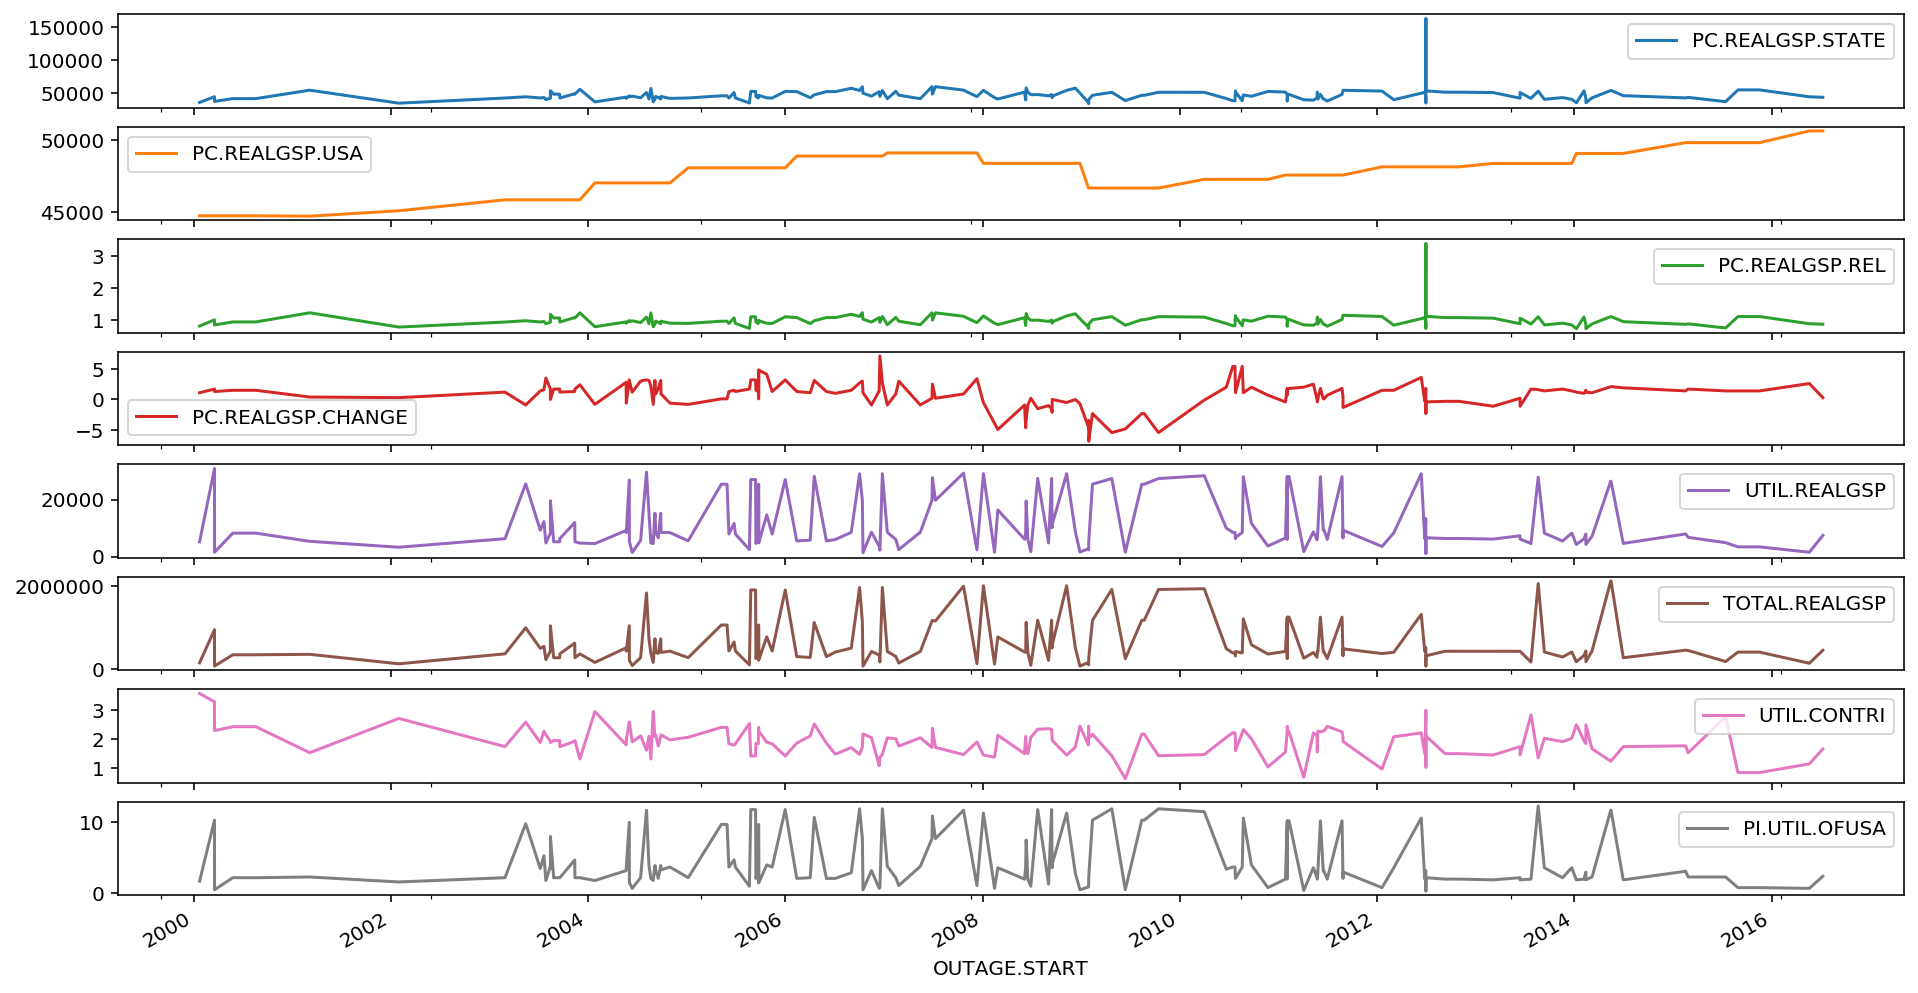

In [65]:
major_outage.plot(subplots=True, x='OUTAGE.START', y=econ_chara, style='-', figsize=(16,9))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8030321d30>,
      dtype=object)

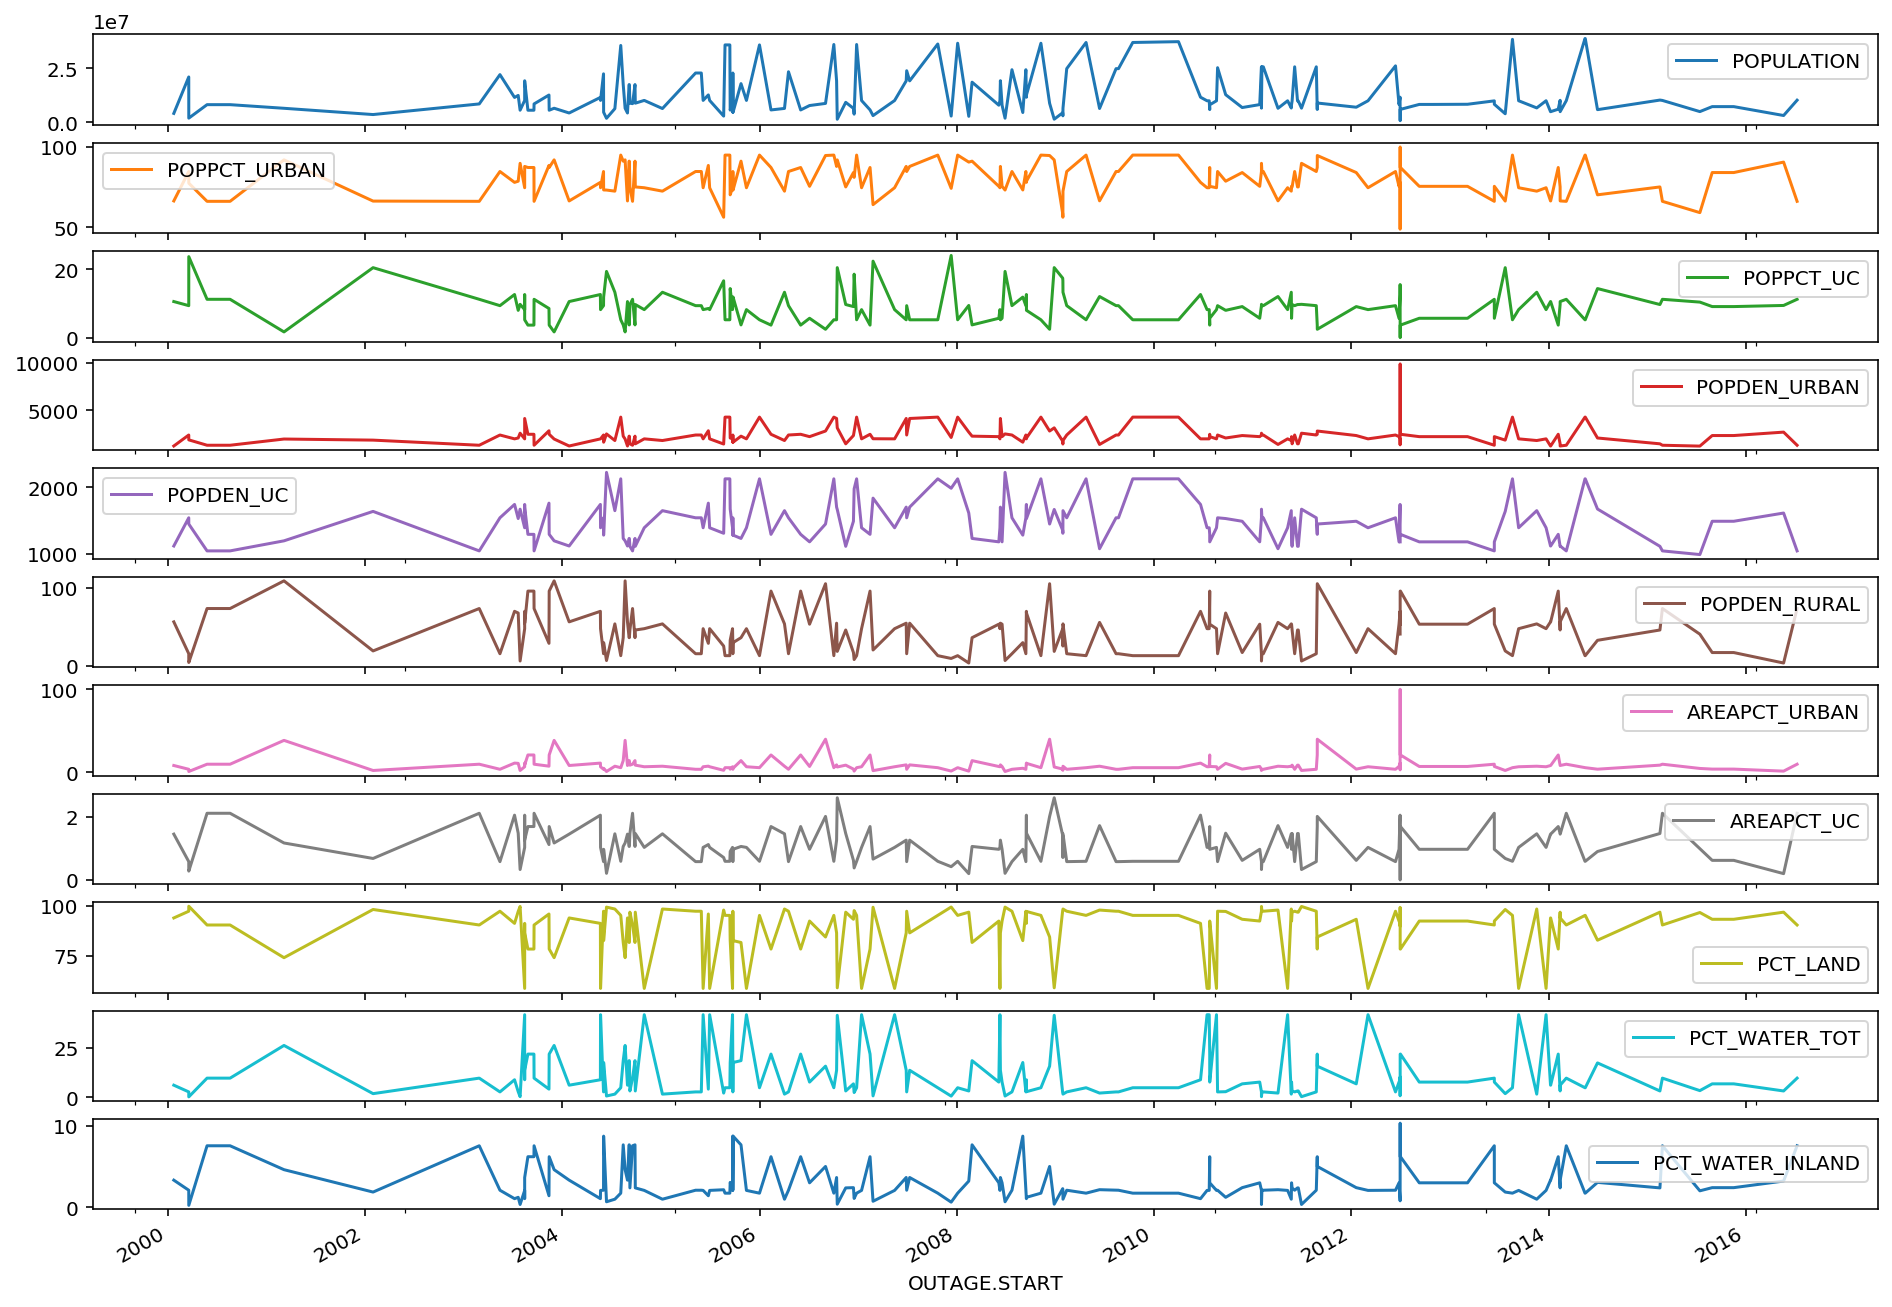

In [68]:
major_outage.plot(subplots=True, x='OUTAGE.START', y=land_chara, style='-', figsize=(16,12))

## Assessment of Missingness

In [94]:
# outage.info()# .isnull().mean()

In [69]:
def missingness_check(outage, column, title, N=1000):
    """check the missingness of columns on all other cols in outage"""
    demand_miss = outage.assign(IS_NULL=outage[column].isnull())
    cols = outage.columns.drop([column]) # Columns to check
    
    for i in range(len(cols)): # Check missingness
        col = cols[i] # Get the columns

        # Different cols have different functions
        if demand_miss[col].dtype == int or demand_miss[col].dtype == float: # Number type
            func = util.diff_in_means # Difference in means
            stats, obs = (util.permutation_test(demand_miss, # Perform permutation test
                                            col, 'IS_NULL', # Dep col, check col
                                            func, N)) # Function, trials
            p_val = np.min([np.count_nonzero(np.array(stats) <= obs) / N, 
                            np.count_nonzero(np.array(stats) >= obs) / N]) # P-value

        elif demand_miss[col].dtype == object: # String Type
            func = util.tvd # Total Variation Distance
            stats, obs = (util.permutation_test(demand_miss, # Perform permutation test
                                            col, 'IS_NULL', # Dep col, check col
                                            func, N)) # Function, trials
            p_val = np.count_nonzero(np.array(stats) >= obs) / N # P-value

        else: # Datetime continuous category type
            func = util.ks # KS statistic
            stats, obs = (util.permutation_test(demand_miss, # Perform permutation test
                                            col, 'IS_NULL', # Dep col, check col
                                            func, N)) # Function, trials
            p_val = np.count_nonzero(np.array(stats) >= obs) / N # P-value

        if p_val > 0.05:
            # util.plot_distribution(stats, obs, i, title, col, p_val) # Plot distribution
            print(title + col + ', p_val is ' + str(p_val))
    return

### 1) Missingness of Demand Loss

In [93]:
# Missingness of Demand Loss
missingness_check(outage, 'DEMAND.LOSS.MW', 'Demand Loss Dependence on ')

Demand Loss Dependence on MONTH, p_val is 0.135
Demand Loss Dependence on CLIMATE.CATEGORY, p_val is 0.32
Demand Loss Dependence on OUTAGE.DURATION, p_val is 0.346
Demand Loss Dependence on CUSTOMERS.AFFECTED, p_val is 0.067
Demand Loss Dependence on RES.PRICE, p_val is 0.192
Demand Loss Dependence on COM.PRICE, p_val is 0.215
Demand Loss Dependence on TOTAL.PRICE, p_val is 0.249
Demand Loss Dependence on IND.SALES, p_val is 0.462
Demand Loss Dependence on RES.PERCEN, p_val is 0.213
Demand Loss Dependence on IND.CUST.PCT, p_val is 0.18
Demand Loss Dependence on PC.REALGSP.STATE, p_val is 0.176
Demand Loss Dependence on PC.REALGSP.REL, p_val is 0.168
Demand Loss Dependence on PC.REALGSP.CHANGE, p_val is 0.236
Demand Loss Dependence on UTIL.CONTRI, p_val is 0.358
Demand Loss Dependence on POPDEN_RURAL, p_val is 0.146
Demand Loss Dependence on AREAPCT_URBAN, p_val is 0.25
Demand Loss Dependence on AREAPCT_UC, p_val is 0.497
Demand Loss Dependence on PCT_LAND, p_val is 0.123
Demand Loss De

### 2) Missingness of Customers Affected

In [98]:
# Missingness of Customers Affected
missingness_check(outage, 'CUSTOMERS.AFFECTED', 'Affected Customers Dependence on ')

Affected Customers Dependence on CLIMATE.CATEGORY, p_val is 0.35
Affected Customers Dependence on RES.PRICE, p_val is 0.279
Affected Customers Dependence on IND.PRICE, p_val is 0.201
Affected Customers Dependence on TOTAL.PRICE, p_val is 0.244
Affected Customers Dependence on RES.SALES, p_val is 0.119
Affected Customers Dependence on COM.SALES, p_val is 0.42
Affected Customers Dependence on IND.SALES, p_val is 0.08
Affected Customers Dependence on TOTAL.SALES, p_val is 0.253
Affected Customers Dependence on RES.PERCEN, p_val is 0.41
Affected Customers Dependence on COM.PERCEN, p_val is 0.499
Affected Customers Dependence on IND.PERCEN, p_val is 0.405
Affected Customers Dependence on PC.REALGSP.REL, p_val is 0.251
Affected Customers Dependence on PC.REALGSP.CHANGE, p_val is 0.309
Affected Customers Dependence on PI.UTIL.OFUSA, p_val is 0.469
Affected Customers Dependence on POPPCT_URBAN, p_val is 0.056


### 3) Imputation

### 4) Analysis after imputation

## Hypothesis Test

### 1) Predicting characteristics of major outage severity

In [70]:
# TODO

### 2) Predicting characteristics of cause category